**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

### RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
- n_estimators : 예측기 갯수


- 모두 과적합을 방지하기 위해서 사용
- min_samples_leaf:

    : 트리가 자라날 깊이에 제한을 줄 수 있습니다. 
    이 값이 3이라면, 단말노드가 표현하는 조건을 만족하는 지점에 최소 3개의 데이터가 포함될때 트리는 학습을 중단합니다. 
    만약 데이터가 1개가 남을때 까지 트리를 계속해서 분할한다면, 특정 케이스에만 맞아들어가는 트리의 형태가 될 가능성이 있습니다.
    노드가 되려면 가지고 있어야할 최소 샘플 수, 값을 2배로 늘릴 때마다 트리의 한 층이 없어지는 것과 같다. 최초의? 단말노드의 갯수를 min_samples_leaf의 수로 나누면 현재의 단말노드 갯수를 알 수 있다.
    
    

- max_features: 

    :각 트리가 어떤 결정을 내려서 분기가 만들어지는 그 순간마다 바라봐야할 특징(feature/열)의 갯수를 제한합니다. 0.5면 무작위로 전체 특징 중 절반만을 사용하게 되겠죠.
    예를 들어서, x 라는 특징이 너무나도 예측 능력이 뛰어난 경우, 모든 트리는 그 특징에만 의존해서 트리를 만들어 나가게될 것입니다. 하지만 특징 외에도 예측을 도울만한 다양한 특징들이 있을 수 있을 겁니다. 때로는 그 예측력이 좋은 커럼이 제한되는것이 바람직할 수 있습니다.

## max_features
![max_features_image](https://scontent-ssn1-1.xx.fbcdn.net/v/t1.6435-9/69576054_10215621198628387_2257255083576131584_n.jpg?_nc_cat=105&ccb=1-3&_nc_sid=b9115d&_nc_ohc=yYyLMAyOC30AX_68bCo&_nc_ht=scontent-ssn1-1.xx&oh=1496d37c93400d7b1b1494af6aab8bae&oe=60ACACD0)

In [6]:
import sys

print("--sys.version--")
print(sys.version)

--sys.version--
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [7]:
%load_ext autoreload
%autoreload 2

In [12]:
%matplotlib inline

from fastai.imports import *
# from fastai.structured import *
from fastai.tabular import *   # from fastai.structured import * 에서 바뀐 버전
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [13]:
import fastai
print(fastai.__version__)

2.3.0


In [14]:
def set_plot_sizes(sml, med, big):
    plt.rc('font', size=sml)          # controls default text sizes
    plt.rc('axes', titlesize=sml)     # fontsize of the axes title
    plt.rc('axes', labelsize=med)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=sml)    # fontsize of the tick labels
    plt.rc('legend', fontsize=sml)    # legend fontsize
    plt.rc('figure', titlesize=big)  # fontsize of the figure title
    
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [16]:
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1


def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict



PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [9]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [8]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [11]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1.320192e+09
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1.320192e+09
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1.320192e+09
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1.319501e+09


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).
- 신뢰 구간은 두 가지 주요 목적으로 사용될 수 있습니다.
- 그룹화 하여 그룹에 따라 평균 신뢰 구간을 볼 수 있습니다. 이렇게 하면 신뢰도가 낮아 보이는 그룹을 찾을 수 있습니다.

### set_rf_samples()
![set_rf_samples_image](https://cphinf.pstatic.net/mooc/20191128_70/1574900873309UikBe_PNG/1_sOceYZ4t5xz3CCrxGSlYCg.png)

In [12]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
set_rf_samples(50000)

In [13]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20605840641706083, 0.24866694610319612, 0.9112608019251411, 0.8895707568722958, 0.8941866126313387]


### RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
- n_estimators : 예측기 갯수
- min_samples_leaf : 노드가 되려면 가지고 있어야할 최소 샘플 수, 값을 2배로 늘릴 때마다 트리의 한 층이 없어지는 것과 같다. 최초의? 단말노드의 갯수를 min_samples_leaf의 수로 나누면 현재의 단말노드 갯수를 알 수 있다.


- 모두 과적합을 방지하기 위해서 사용
- min_samples_leaf:

    : 트리가 자라날 깊이에 제한을 줄 수 있습니다. 
    이 값이 3이라면, 단말노드가 표현하는 조건을 만족하는 지점에 최소 3개의 데이터가 포함될때 트리는 학습을 중단합니다. 
    만약 데이터가 1개가 남을때 까지 트리를 계속해서 분할한다면, 특정 케이스에만 맞아들어가는 트리의 형태가 될 가능성이 있습니다.
    
    

- max_features: 

    :각 트리가 어떤 결정을 내려서 분기가 만들어지는 그 순간마다 바라봐야할 특징(feature/열)의 갯수를 제한합니다. 0.5면 무작위로 전체 특징 중 절반만을 사용하게 되겠죠.
    예를 들어서, x 라는 특징이 너무나도 예측 능력이 뛰어난 경우, 모든 트리는 그 특징에만 의존해서 트리를 만들어 나가게될 것입니다. 하지만 특징 외에도 예측을 도울만한 다양한 특징들이 있을 수 있을 겁니다. 때로는 그 예측력이 좋은 커럼이 제한되는것이 바람직할 수 있습니다.

We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [14]:
!pwd

/c/Users/wjdqh/fastai


In [15]:
# 예측결과의 표준편차 사용 (평균 대신에) 

In [16]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_]) # 단일 CPU에서 연속으로 실행
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 2.15 s


(9.272312354605882, 0.2916335342058341)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [17]:
def parallel_trees(m, fn, n_jobs=8):
        return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))
# 병렬처리 가능
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(9.272312354605882, 0.2916335342058341)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

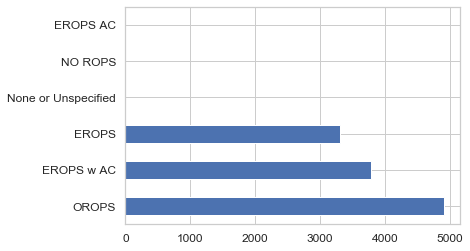

In [18]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [19]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.837721,0.275538
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.579398,0.263945
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684072,0.224160


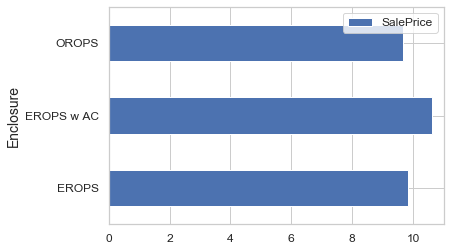

In [20]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

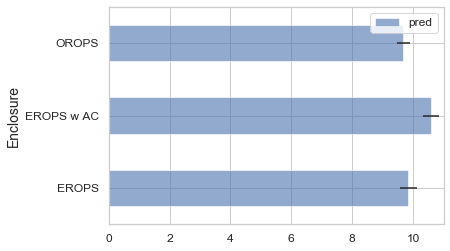

In [21]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

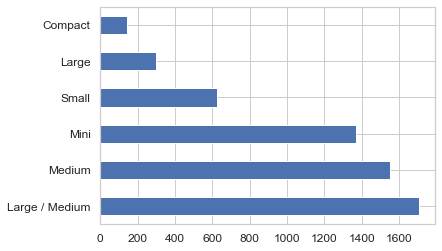

In [22]:
raw_valid.ProductSize.value_counts().plot.barh();

In [23]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.882688,0.341112
Large,10.470589,10.381415,0.357745
Large / Medium,10.691871,10.650169,0.296671
Medium,10.681511,10.625101,0.283737
Mini,9.535147,9.561054,0.249001
Small,10.324448,10.322414,0.308741


In [24]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.034516
Large             0.034460
Small             0.029910
Large / Medium    0.027856
Medium            0.026704
Mini              0.026043
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.
- 특정한 행을 확인하는 것도 중요합니다. 제품화 하는 단계에서는 신뢰 구간을 항상 보고 싶을 것입니다. 만약 신용평가를 통한 대출을 결정할 때 누구에게 대출을 해 줄지 결정하는 것뿐 아니라 위험레벨과 신뢰도 또한 봐야합니다. 또한 누군가 돈을 많이 빌리고 싶은데 갚을지 예측하는데 있어서 신뢰할 수 없다면 돈을 많이 빌려줄 수 없습니다. 
- 가장 중요한 것은 '특성 중요도'입니다. 특성 중요도는 랜덤포레스트에서 어떤 열이 중요한지를 말해줍니다. 
- 사이킷런은 어떤 특성을 사용한 노드가(랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정합니다.
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결과값을 정규화한다. 이 값은 feature_importances_ 변수에 저장되어 있습니다.

In [8]:
# 특성 중요도 예시
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)
    
# 가장 중요한 특성은 꽃잎(petal)의 길이(43%)와 너비(45%)이고 꽃받침의 길이와 너비는 비교적 덜 중요해보인다. (from 핸즈온머신러닝)

sepal length (cm) 0.09864941710857311
sepal width (cm) 0.022212760079823774
petal length (cm) 0.4467597249391539
petal width (cm) 0.4323780978724492


In [25]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.176796
13,ProductSize,0.104219
37,Coupler_System,0.093825
14,fiProductClassDesc,0.074015
39,Hydraulics_Flow,0.068109
2,ModelID,0.058338
63,saleElapsed,0.050361
10,fiSecondaryDesc,0.039437
19,Enclosure,0.035290
8,fiModelDesc,0.030679


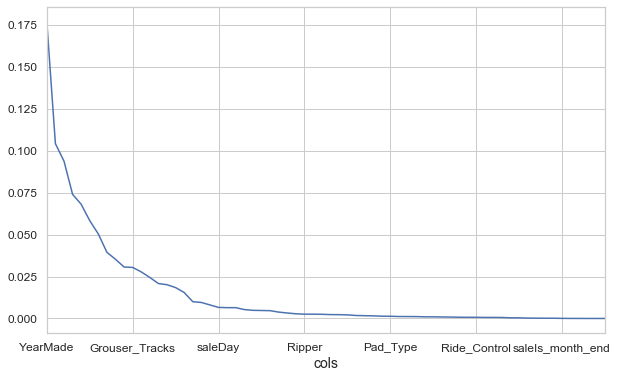

In [26]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [27]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

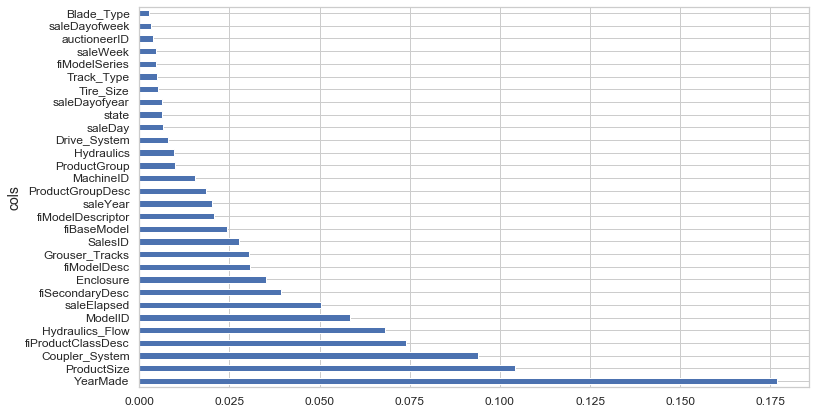

In [28]:
plot_fi(fi[:30]);
# data leakage 에 신경써라   데이터 누수!? 

In [29]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [30]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [31]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.206694795781504, 0.24536765309581673, 0.9107118324580026, 0.8924816497663203, 0.8943753556880537]


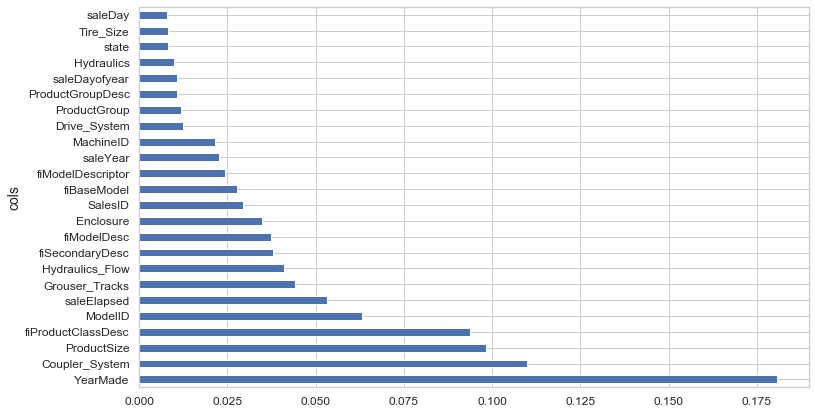

In [32]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [9]:
proc_df??

'''
proc_df()에는 DataFrame과 의존 컬럼명을 인자로 주면
그 컬럼을 DataFrame으로 부터 추출 해서 독립적으로 따로 저장을 하고 원본 DataFrame에선 이 컬럼을 삭제하게 됩니다.


이 코드가 수행된 후 리턴되는 df에는 더 이상 Sales라는 컬럼이 존재하지 않게 되는 것입니다.
반면에, 리턴된 y에는 Sales 컬럼의 내용이 담기게 됩니다.

'''

'\nproc_df()에는 DataFrame과 의존 컬럼명을 인자로 주면\n그 컬럼을 DataFrame으로 부터 추출 해서 독립적으로 따로 저장을 하고 원본 DataFrame에선 이 컬럼을 삭제하게 됩니다.\n\n\n이 코드가 수행된 후 리턴되는 df에는 더 이상 Sales라는 컬럼이 존재하지 않게 되는 것입니다.\n반면에, 리턴된 y에는 Sales 컬럼의 내용이 담기게 됩니다.\n\n'

In [34]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)  # 7보다 작은 단계를 가지는 것은 원-핫 인코딩으로 변함
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


'''
결과가 조금 더 안좋아짐
데이터셋에 따라 달라짐 : 하나의 카테고리의 중요도에 따라 결과 변동 발생

[0.2072721509809848, 0.25369498350888126, 0.910212323163593, 0.8850598569314425, 0.8925184315828779]
'''

[0.20670639788899042, 0.25269463167077266, 0.9107018084030922, 0.8859645172460832, 0.8931551749462437]


'\n결과가 조금 더 안좋아짐\n데이터셋에 따라 달라짐 : 하나의 카테고리의 중요도에 따라 결과 변동 발생\n\n[0.2072721509809848, 0.25369498350888126, 0.910212323163593, 0.8850598569314425, 0.8925184315828779]\n'

In [35]:
df_trn2.head(2).iloc[0]

SalesID                                  1139246
MachineID                                 999089
ModelID                                     3157
datasource                                   121
auctioneerID                                   3
                                          ...   
Steering_Controls_Conventional                 1
Steering_Controls_Four Wheel Standard          0
Steering_Controls_No                           0
Steering_Controls_Wheel                        0
Steering_Controls_nan                          0
Name: 0, Length: 173, dtype: object

In [36]:
sorted(df_trn2.columns)

['Backhoe_Mounting_None or Unspecified',
 'Backhoe_Mounting_Yes',
 'Backhoe_Mounting_nan',
 'Blade_Extension_None or Unspecified',
 'Blade_Extension_Yes',
 'Blade_Extension_nan',
 'Blade_Type',
 "Blade_Width_12'",
 "Blade_Width_13'",
 "Blade_Width_14'",
 "Blade_Width_16'",
 "Blade_Width_<12'",
 'Blade_Width_None or Unspecified',
 'Blade_Width_nan',
 'Coupler_Hydraulic',
 'Coupler_Manual',
 'Coupler_None or Unspecified',
 'Coupler_System_None or Unspecified',
 'Coupler_System_Yes',
 'Coupler_System_nan',
 'Coupler_nan',
 'Differential_Type_Limited Slip',
 'Differential_Type_Locking',
 'Differential_Type_No Spin',
 'Differential_Type_Standard',
 'Differential_Type_nan',
 'Drive_System_All Wheel Drive',
 'Drive_System_Four Wheel Drive',
 'Drive_System_No',
 'Drive_System_Two Wheel Drive',
 'Drive_System_nan',
 'Enclosure_EROPS',
 'Enclosure_EROPS AC',
 'Enclosure_EROPS w AC',
 'Enclosure_NO ROPS',
 'Enclosure_None or Unspecified',
 'Enclosure_OROPS',
 'Enclosure_Type_High Profile',
 'Encl

In [37]:
y_trn[:5]

array([11.09741002, 10.95080655,  9.21034037, 10.55841352,  9.30565055])

In [38]:
print_score??

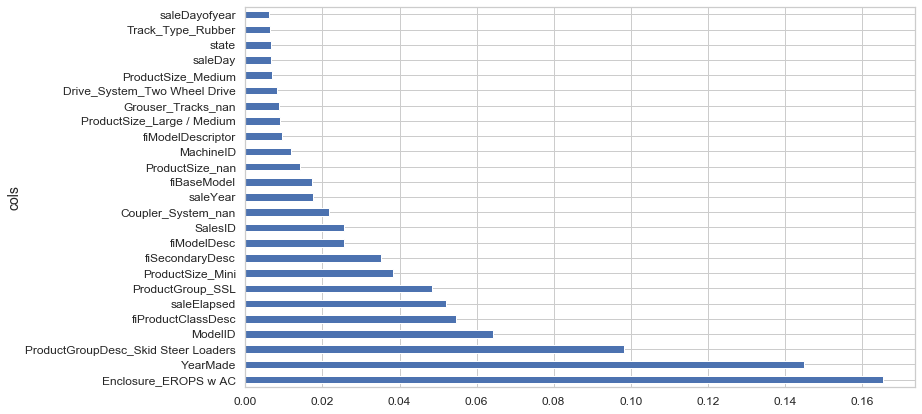

In [39]:
# feature importance 결과가 다르게 생긴 것을 확인
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [40]:
from scipy.cluster import hierarchy as hc

In [41]:
'''
스피어먼 상관 계수는 순위가 매겨진 변수 간의 피어슨 상관 계수 로 정의된다.[1] 
따라서 통계적 계산에서 순서척도가 적용되는 상관분석에서는 스피어먼 상관 계수가 사용되며 간격척도가 적용되는 변수들 간의 분석에서는 
피어슨 상관 계수가 사용된다.
두 변수 의 순위 사이의 통계적 의존성을 측정하는 비모수적인 척도이다. 
'''

'\n스피어먼 상관 계수는 순위가 매겨진 변수 간의 피어슨 상관 계수 로 정의된다.[1] \n따라서 통계적 계산에서 순서척도가 적용되는 상관분석에서는 스피어먼 상관 계수가 사용되며 간격척도가 적용되는 변수들 간의 분석에서는 \n피어슨 상관 계수가 사용된다.\n두 변수 의 순위 사이의 통계적 의존성을 측정하는 비모수적인 척도이다. \n'

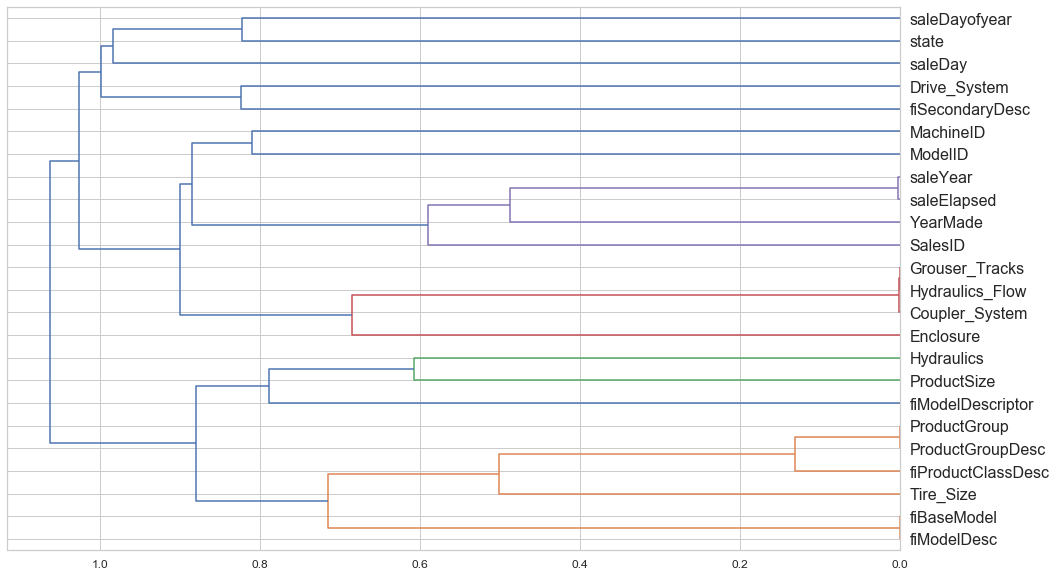

In [42]:
# 덴드로그램 : 계층적 군집화 <- 강의에선 불필요한 특성을 제거하기 위해 사용함
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

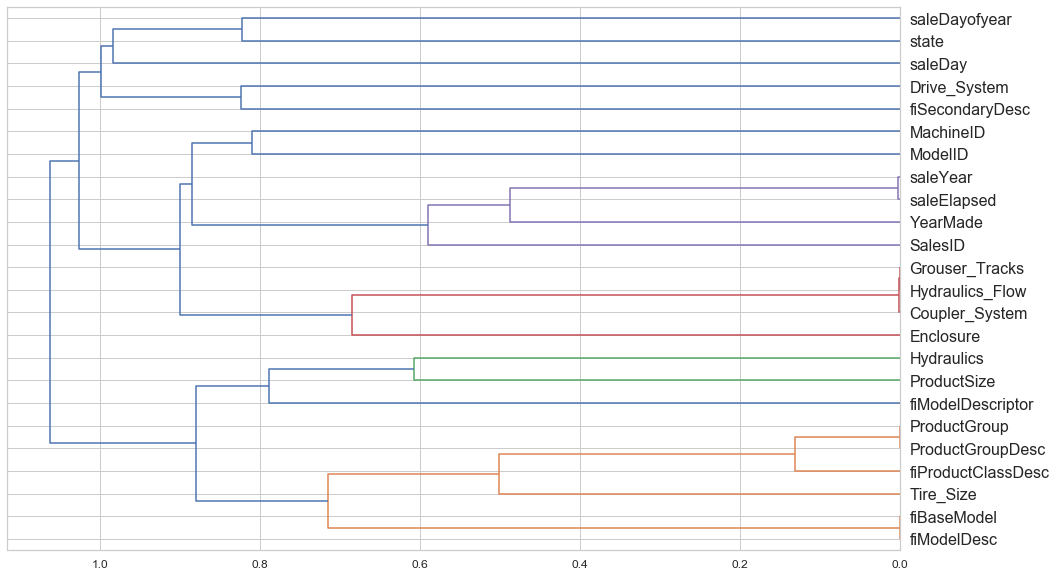

In [43]:
corr = df_keep.corr(method='spearman')
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

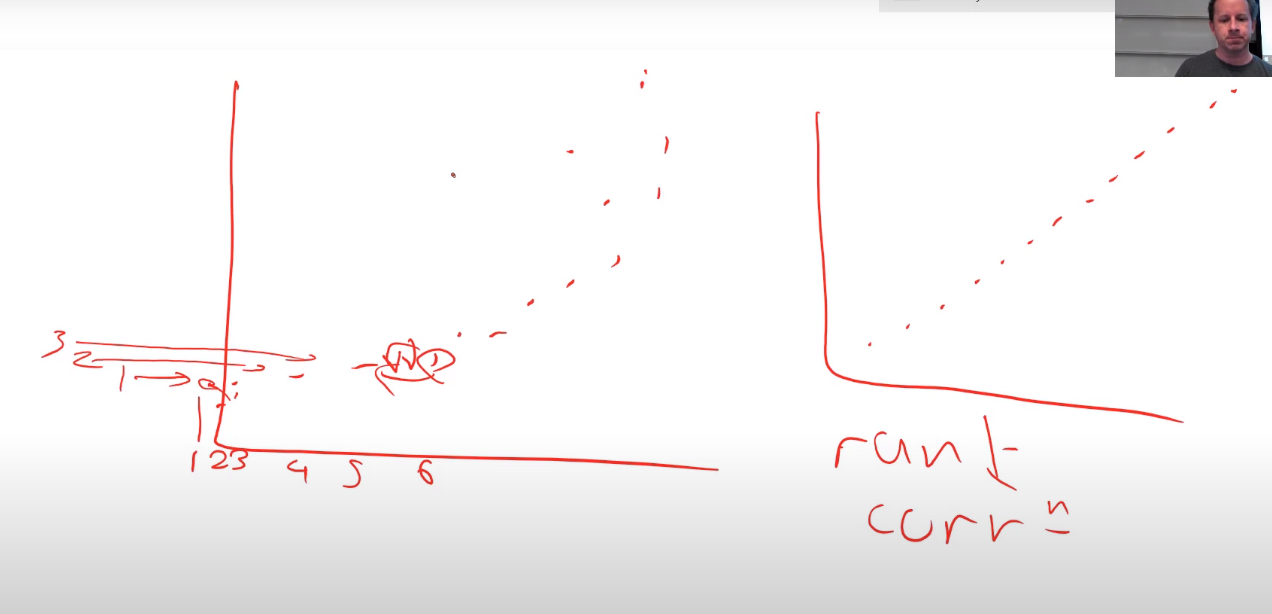

In [44]:
df_keep.head()

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,Hydraulics_Flow,ModelID,saleElapsed,fiSecondaryDesc,Enclosure,fiModelDesc,...,saleYear,ProductGroupDesc,MachineID,ProductGroup,Hydraulics,Drive_System,saleDay,state,saleDayofyear,Tire_Size
0,2004,0,0,59,0,3157,1.163635e+09,41,3,950,...,2006,6,999089,6,1,0,16,1,320,17
1,1996,4,0,62,0,77,1.080259e+09,55,3,1725,...,2004,6,117657,6,1,0,26,33,86,12
2,2001,0,1,39,3,7009,1.077754e+09,0,6,331,...,2004,3,434808,3,4,0,26,32,57,0
3,2001,6,0,8,0,332,1.305763e+09,0,3,3674,...,2011,4,1026470,4,1,0,19,44,139,0
4,2007,0,1,40,3,17311,1.248307e+09,0,1,4208,...,2009,3,1057373,3,4,0,23,32,204,0


Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [45]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [46]:
get_oob(df_keep)

0.8903428702223475

Now we try removing each variable one at a time.

In [47]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8887676040088386
saleElapsed 0.8868851005958152
fiModelDesc 0.8884502264451779
fiBaseModel 0.8889781257493061
Grouser_Tracks 0.8902226445335909
Coupler_System 0.8893542853270602


It looks like we can try one from each group for removal. Let's see what that does.

In [48]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8888629612429935

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [49]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [50]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [51]:
!pwd

/c/Users/wjdqh/fastai


In [52]:
keep_cols = np.load('tmp/keep_cols.npy',allow_pickle=True)
df_keep = df_trn[keep_cols]

In [53]:
df_keep.head()

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,Hydraulics_Flow,ModelID,saleElapsed,fiSecondaryDesc,Enclosure,fiModelDesc,...,fiModelDescriptor,ProductGroupDesc,MachineID,ProductGroup,Hydraulics,Drive_System,saleDay,state,saleDayofyear,Tire_Size
0,2004,0,0,59,0,3157,1.163635e+09,41,3,950,...,0,6,999089,6,1,0,16,1,320,17
1,1996,4,0,62,0,77,1.080259e+09,55,3,1725,...,0,6,117657,6,1,0,26,33,86,12
2,2001,0,1,39,3,7009,1.077754e+09,0,6,331,...,0,3,434808,3,4,0,26,32,57,0
3,2001,6,0,8,0,332,1.305763e+09,0,3,3674,...,0,4,1026470,4,1,0,19,44,139,0
4,2007,0,1,40,3,17311,1.248307e+09,0,1,4208,...,0,3,1057373,3,4,0,23,32,204,0


And let's see how this model looks on the full dataset.

In [54]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))
reset_rf_samples()

In [55]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
[0.2072721509809848, 0.25369498350888126, 0.910212323163593, 0.8850598569314425, 0.8925184315828779]

[0.12575204966523237, 0.22704272109165247, 0.9669504941016989, 0.907941659820892, 0.9087459746555654]


# Partial dependence (부분 의존성)

In [56]:
from pdpbox import pdp
from plotnine import *

In [57]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [58]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

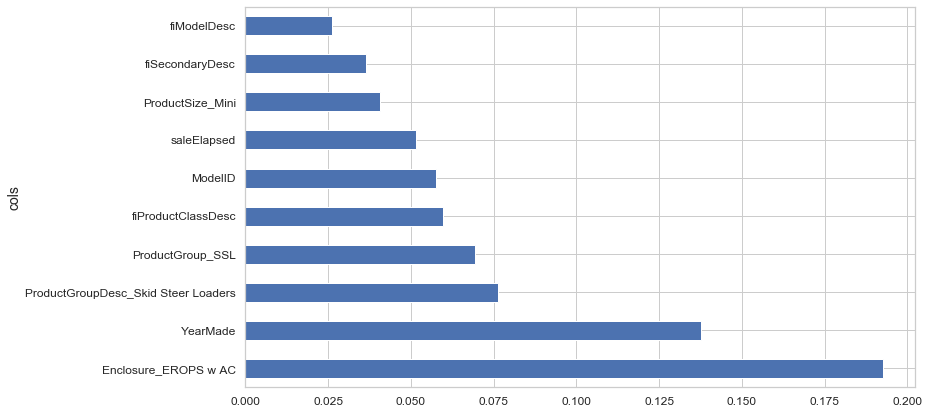

In [59]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


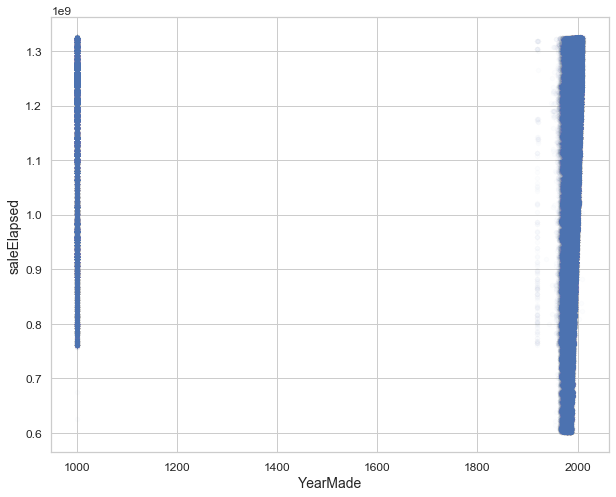

In [60]:
# 얼마나 오래된 제품인지 알 수 있다
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [61]:
def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.
    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.
    Returns:
    --------
    return value: A random sample of n rows of df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

# 데이터를 다 그리긴 어려우니 그릴 샘플 뽑기
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [62]:
# !pip install scikit-misc

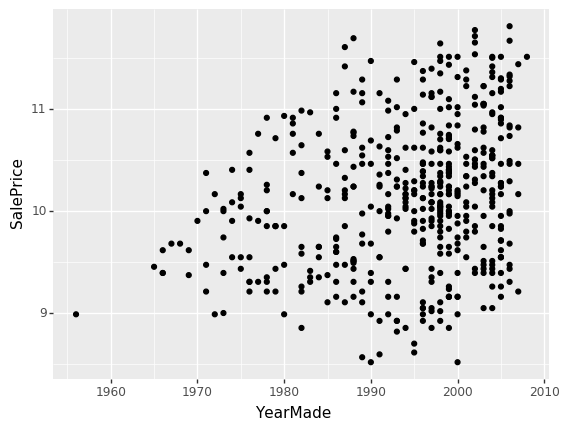

<ggplot: (-9223371894442418011)>

In [63]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + geom_point()
# ggplot(x_all, aes('YearMade', 'SalePrice')) + geom_line( )

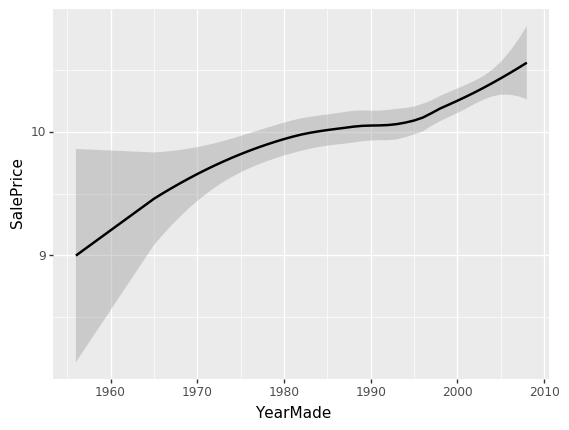

<ggplot: (142405064754)>

In [64]:
from plotnine import *
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [65]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [71]:
# def plot_pdp(feat, clusters=None, feat_name=None):
#     feat_name = feat_name or feat
#     p = pdp.pdp_isolate(m, x, feat)
#     return pdp.pdp_plot(p, feat_name, plot_lines=True,
#                         cluster=clusters is not None,
#                         n_cluster_centers=clusters)
def plot_pdp(feat_name, clusters=None):
#feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                   cluster=clusters is not None, n_cluster_centers=clusters)

In [72]:
# !pip install pdpbox==0.2.0

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21280600860>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x21280aa1588>})

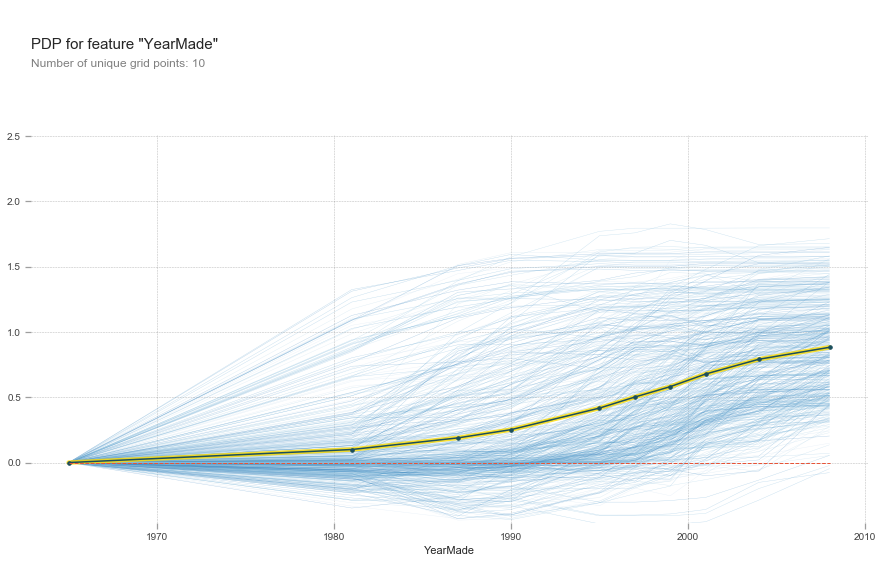

In [73]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp
plot_pdp('YearMade')

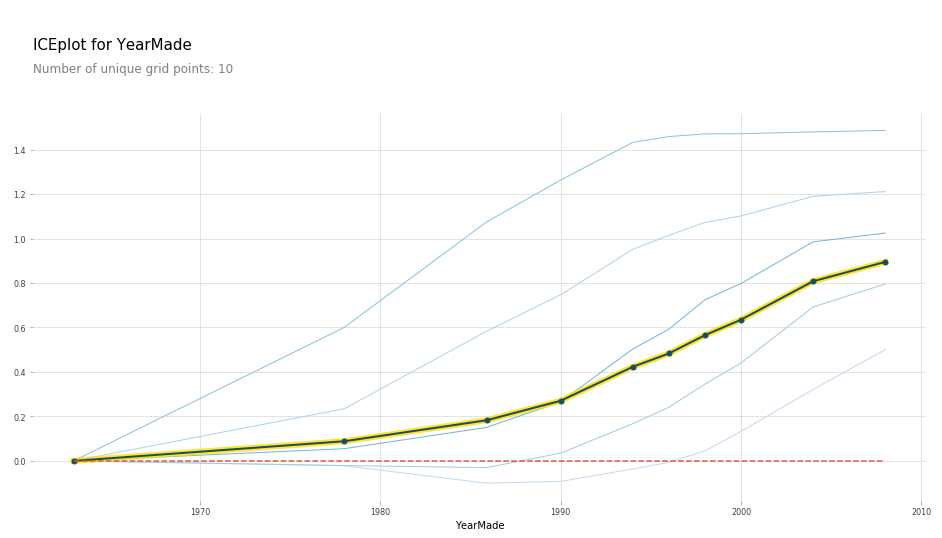

In [ ]:
plot_pdp('YearMade', clusters=5)

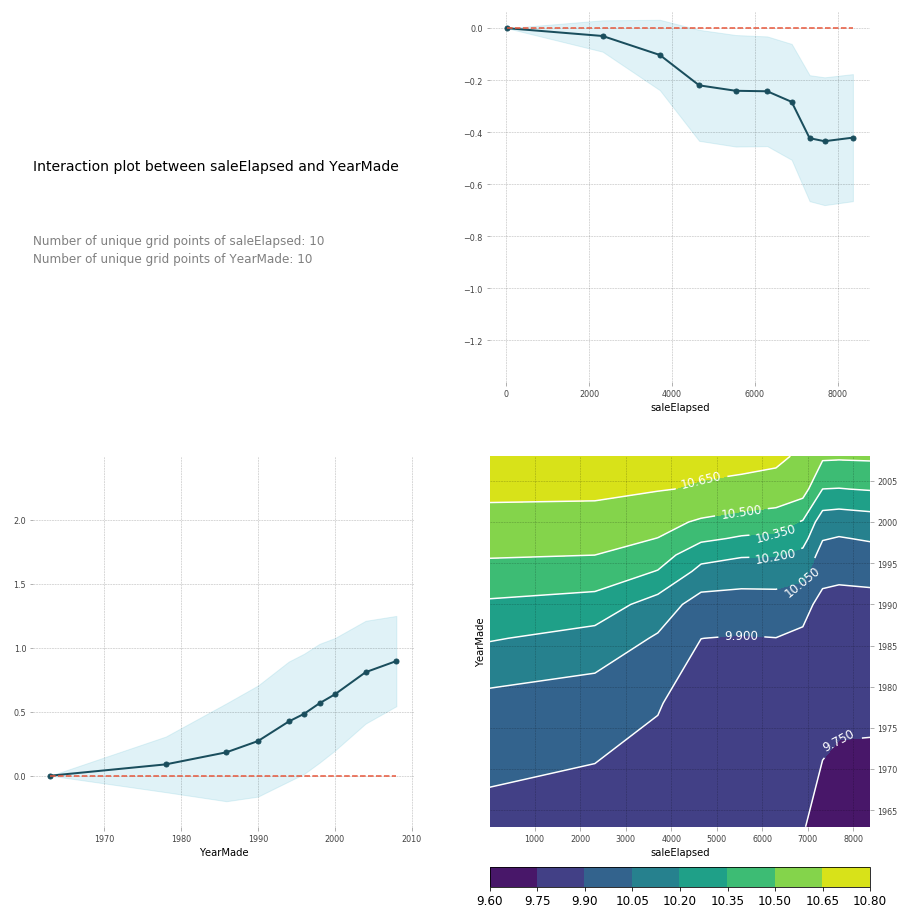

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

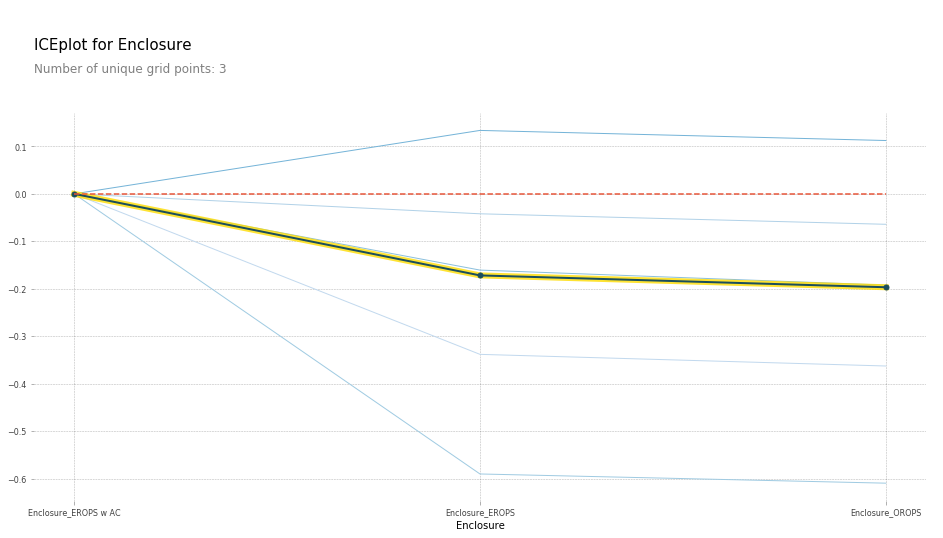

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

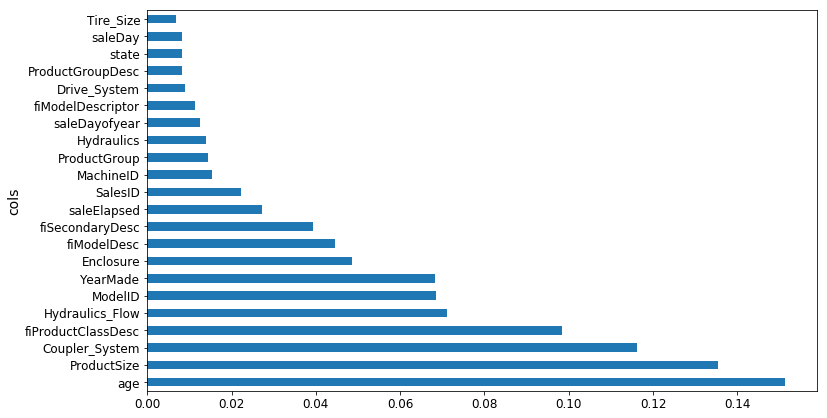

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

    !pip install waterfallcharts
    !pip install treeinterpreter

In [19]:
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    name = "Value Changed", orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "total"],
    x = ['All', 'Coupler<=0.5', 'Enclosure<=2', 'ModelID<=4573', 'Total'],
    textposition = "outside",
    text = ['10.189','0.156','-0.395','0.276', "Total"],
    y = [10.189,0.156,-0.395,0.276, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Tree Step",
        showlegend = True
)

fig.show()

In [5]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 3, 3232, 1111, 0, 63, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9, 37,
        16, 3, 259, False, False, False, False, False, False, 7912, False, False]], dtype=object)

In [ ]:
# 예측값, 모든 데이터의 평균 판매가, 트리에 나타나는 특정 열에 있는 모든 기여도를 합친 값
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

(9.1909688098736275, 10.10606580677884)

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
# 기여도 확인
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54680742853695008),
 ('age', 11, -0.12507089451852943),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
 ('fiModelDesc', 'KX1212', -0.065155113754146801),
 ('fiSecondaryDesc', nan, -0.055237427792181749),
 ('Enclosure', 'EROPS', -0.050467175593900217),
 ('fiModelDescriptor', nan, -0.042354676935508852),
 ('saleElapsed', 7912, -0.019642242073500914),
 ('saleDay', 16, -0.012812993479652724),
 ('Tire_Size', nan, -0.0029687660942271598),
 ('SalesID', 4364751, -0.0010443985823001434),
 ('saleDayofyear', 259, -0.00086540581130196688),
 ('Drive_System', nan, 0.0015385818526195915),
 ('Hydraulics', 'Standard', 0.0022411701338458821),
 ('state', 'Ohio', 0.0037587658190299409),
 ('ProductGroupDesc', 'Track Excavators', 0.0067688906745931197),
 ('ProductGroup', 'TEX', 0.014654732626326661),
 ('MachineID', 2300944, 0.015578052196894499),
 ('Hydraulics_Flow', nan, 0.028973749866174004),
 ('ModelID', 665, 0.0383074

In [ ]:
contributions[0].sum()  # 해당 값을 더해주면 최종 예측값이 나온다(?)

-0.7383536391949419

# Extrapolation (외삽법)
- OOB score와 Validation score의 큰 차이 발생 시 고려하는 방법
- 시간이라는 변수를 통해 예측하지 않고, 시간 이외에 더 훌륭한 예측값을 주는, 혹은 더 밀접한 관계를 가진 변수를 찾는다.
    1. 검증용 데이터셋과 학습용 데이터셋 사이에 어떤 차이가 있는지를 알아낸다. <- 이 차이를 알아낸다면 어떤 예측 요인이 강한 시간적 요소를 가지고 있는지를 알 수 있다. 그리고 그 요소들은 미래의 시간으로 갈수록 부적잘한 요소가 될 수 있다!

In [ ]:
df_ext = df_keep.copy()

# is_valid라는 것을 종속변수로 랜덤 포레스트 만들기 : 특정 행이 검증용 데이터셋에 포함되는지를 체크하는 열
df_ext['is_valid'] = 1
# 학습용 데이터는 is_valid == 0
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
# 모델 생성 : 검증용 데이터셋에 있는지를 예측하는 모델 (가격예측모델이 아니라는 점을 유의!)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [ ]:
# 각 특성들의 중요도 확인
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [ ]:
(X_valid[feats]/1000).describe()

# train과 valid 값의 분포? 가 너무 다른 특성은 제외한다.

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [ ]:
# 위의 특성 제거한 후의 특성 중요도 확인
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [ ]:
set_rf_samples(50000)

In [ ]:
# 시간 종속적 특성들
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [ ]:
reset_rf_samples()

In [ ]:
# 제거 후 validation score가 향상된 특성 골라내기
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


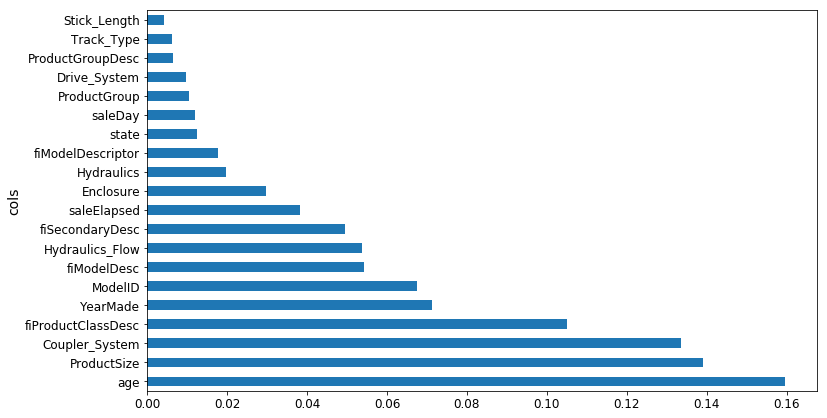

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
